In [2]:
from tooldev import RST
from tooldev.sample import bootstrap

from itertools import combinations

import re
import random
import json
import numpy as np
import pandas as pd
import collections

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KernelDensity

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# data = pd.read_csv('datasets/d1.csv') # Orignal Dataset shape (381109, 11)
# data = data.drop(['id'], axis=1)

data = pd.read_csv('datasets/d1_bootstraped.csv')

# data_2 = pd.read_csv('datasets/d2.csv')

In [4]:
# Uncomment for creating a new sample of the datasets with bootstrap
# freq = pd.DataFrame({'Response':['0', '1'], 'nostoextract':[46710, 46710], })
# data = bootstrap(data,freq)

Gender                    2
Driving_License           1
Region_Code              34
Previously_Insured        2
Vehicle_Age               3
Vehicle_Damage            2
Annual_Premium          170
Policy_Sales_Channel     23
Response                  2
dtype: int64

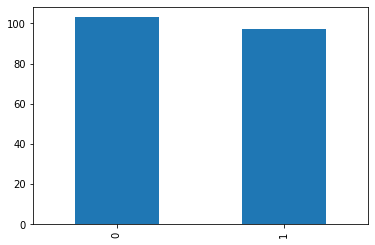

In [5]:
df = data.copy()
df = df.sample(200, random_state=41) # 24
df['Response'].value_counts().plot(kind='bar')
df.drop(['Vintage', 'Age'], axis=1, inplace=True)
df.nunique()

In [22]:
# %%time


class Error(Exception):
    """Base class for other exceptions"""
    pass


class NotMatchResult(Error):
    """Raised when the input value is too small"""
    pass


class DRST:
    '''
        An Efficient Discretization Algorithm Using Rough Set Theory

        ...

        Attributes
        ----------
        checker_type : str='topN'
            Type of the checker of data to determind wether data column is Continous or Discrete

        Methods
        -------
        fit(x: DataFrame, continous_columns: list)

        Note
        -------

        Example
        -------


    '''

    def __init__(
        self,
        checker_type: str = 'topN',
        comb_max_depth: int = None,
        decision_column_name: str = 'class',
    ):

        # Primary Data Information
        self.data = None
        self.prepared_data = None
        self.columns = None
        self.continuous_columns = None
        self.discrete_columns = None
        self.scaled_data = None
        self.decision_column_name = decision_column_name

        # Secondary Data infromation
        self.data_after_INI = None
        self.silhouette_scores = None
        self.lower_edge_value = {}
        self.upper_edge_value = {}
        self.outer_edge_value = {}
        
        # check_discrete
        self.dis_check_threshold = 0.5
        self.dis_checker = checker_type  # ratio
        self.checker_top_n = 10  # defult number of top N for topN checker

        # Config Tools
        self.rst = None
        self.encoder = LabelEncoder()
        self.encoder_dict = dict()
        self.scaler = StandardScaler()
        self.natural_interval_model = 'kmeans'
        self.NIM_message = 'Model for initiat the natural intervals cannot be blank'
        self.comb_max_depth = comb_max_depth
        self.all_combinations = None

    def fit(
            self,
            x: pd.DataFrame,
            continous_columns: list = [],
            natural_interval_model: str = 'kmeans'
    ):
        """Discretization using Rough Sets Theory (RST).

        Fit `x` to an efficient intervals using the concept of RST 
        * asd
        Parameters
        ----------
        x : DataFrame
            Full DataFrame (default is None)

        continous_columns : list
            Determind names of column(s) in the DataFarme as Continuous data. If `None` a function _check_continuous triger to determind names of column(s).

        Raises
        ------
        NotMatchResult
            If continous_columns `~None` model check the input with the checker determation if didn't match the result

        """

        # Reduct Data Intervals phase: Pre-process of discretization, intiate classification
        # Pre-process of discretization
        self.data = x
        self.columns = self.data.columns
        self.continuous_columns = continous_columns if continous_columns else self._check_continuous()
        self.discrete_columns = list(set(self.columns).difference(self.continuous_columns))
        self.discrete_columns.remove(self.decision_column_name)
        self.scaled_data = self._scaling_continuous()
        self.silhouette_scores = self._get_silhouette_score()

        # Intiate classification
        self.data_after_INI = getattr(self, '_%s_model' % natural_interval_model, lambda: self.NIM_message)()
        print(self.data_after_INI.nunique())
        self.data_after_INI.sort_values(['Annual_Premium']).to_csv('%s_model.csv' % natural_interval_model)
        self.all_combinations = self.get_combinations()

        data = self.data.copy()  # local datavriable to save change in
        # data[self.continuous_columns] = self.data_after_INI.to_numpy()
        data = self._labeling_discrete(data)
        self.data_after_INI[[(i + '_STAT') for i in self.data_after_INI.columns]] = self.data_after_INI[self.data_after_INI.columns]
        self.data_after_INI.columns = map((lambda x: x + '_AFTER'), self.data_after_INI.columns)

        data = pd.concat([
            data.reset_index(drop=True),
            self.data_after_INI.reset_index(drop=True)
        ], axis=1)

        dep = {}
        org_dep = {}

        # Duplicate Continuous columns
        for continuous_att in self.continuous_columns:
            self.prepared_data = data.copy()
            self.prepared_data = data.sort_values([continuous_att + '_AFTER', continuous_att])
            label_simulator = self.silhouette_scores[continuous_att]
            for combination in self.all_combinations:
                _combination = list(combination)
                _combination.append(continuous_att + '_AFTER')
                self.rst = RST(
                    self.prepared_data,
                    continuous_columns=self.continuous_columns,
                    decision_column_name=self.decision_column_name,
                    include_continuous_col=True
                )
                lower, dependency = self.rst.get_dependency(
                    combination=list(_combination)
                )
                
                org_dep.update({
                        '_'.join(i for i in _combination): dependency
                    })
                
                for value in range(0, label_simulator):
                    self.lower_data = data.copy()
                    self.upper_data = data.copy()
                    self.both_data = data.copy()
                    indices = self.prepared_data[self.prepared_data[continuous_att + '_AFTER'] == value].index.tolist()
                    if value not in dep.keys():
                        dep.update({value: {
                            'lower':[], 
                            'upper':[]
                            }})

                    self._set_lower_edge_value(continuous_att, indices, value, label_simulator)
                    self._set_upper_edge_value(continuous_att, indices, value, label_simulator)
                    self._set_outer_edge_values(continuous_att, indices, value)
                    # if len(indices) > 1:
                    if value not in [0]:
                        self.lower_data.loc[self.lower_edge_value[value]['idx'], (continuous_att + '_AFTER')] = value + 1
                        # self.both_data.loc[self.lower_edge_value[value]['idx'], (continuous_att + '_AFTER')] = value + 1
                        self.rst = RST(
                            self.lower_data,
                            continuous_columns=self.continuous_columns,
                            decision_column_name=self.decision_column_name,
                            include_continuous_col=True
                        )
                        lower, dependency = self.rst.get_dependency(
                            combination=list(_combination)
                        )
                        dep[value]['lower'].append(dependency)

                
                    if value not in [(label_simulator - 1)]:
                        self.upper_data.loc[self.upper_edge_value[value]['idx'], (continuous_att + '_AFTER')] = value - 1
                        # self.both_data.loc[self.upper_edge_value[value]['idx'], (continuous_att + '_AFTER')] = value - 1
                        self.rst = RST(
                            self.upper_data,
                            continuous_columns=self.continuous_columns,
                            decision_column_name=self.decision_column_name,
                            include_continuous_col=True
                        )
                        lower, dependency = self.rst.get_dependency(
                            combination=list(_combination)
                        )
                        dep[value]['upper'].append(dependency)
                    # elif
                    # self.rst = RST(
                    #     self.both_data,
                    #     continuous_columns=self.continuous_columns,
                    #     decision_column_name=self.decision_column_name,
                    #     include_continuous_col=True
                    # )
                    # lower, dependency = self.rst.get_dependency(
                    #     combination=list(_combination)
                    # )
                    # dep[value]['both'].append(dependency)

                    value += 1
        dep = collections.OrderedDict(sorted(dep.items()))       
        with open('dep.json', 'w+') as fp:
            json.dump(dep, fp)
        # print(self.lower_edge_value)
        # print('--------------------------------')
        # print(self.upper_edge_value)
        # print('--------------------------------')
        # print(self.outer_edge_value)
        return self.prepared_data

    def _dbscan_model(self):
        result = {}
        for att in self.continuous_columns:
            clustering = DBSCAN(eps=1, min_samples=5).fit(
                self._np_array_reshaped(self.data[att])
            )
            result[att] = clustering.labels_
        return pd.DataFrame(result)

    def _kmeans_model(self):
        result = {}
        for att in self.continuous_columns:
            clustering = KMeans(n_clusters=self.silhouette_scores[att], random_state=41).fit(
                self._np_array_reshaped(self.scaled_data[att])
            )
            result[att] = clustering.labels_
        return pd.DataFrame(result)

    def _np_array_reshaped(self, data, reshape=(-1, 1)):
        return np.array(data.tolist()).reshape(reshape[0], reshape[1])

    def _check_continuous(self, continous_columns: list = []):
        top_n = self.checker_top_n
        likely = []

        # check if attribute is continuous or discrete dataframe
        for var in self.data.columns:
            if self.dis_checker == 'topN':
                # Check if the top n unique values account for more than a certain proportion of all values
                if 1.*self.data[var].value_counts(normalize=True).head(top_n).sum() < 0.5:
                    likely.append(var)
            elif self.dis_checker == 'ratio':
                # Find the ratio of number of unique values to the total number of unique values. Something like the following
                if 1.*self.data[var].nunique()/self.data[var].count() > 0.5:
                    likely.append(var)

        common_names = ['id']

        return [x for x in likely if x.lower() not in common_names]

    def _labeling_discrete(self, data):

        data_endocded = data.copy()

        for col in data_endocded:
            if col not in self.continuous_columns:
                le = self.encoder.fit(data_endocded[col])
                data_endocded[col] = self.encoder.transform(data_endocded[col])
                self.encoder_dict[col] = self.encoder
        return data_endocded

    def _scaling_continuous(self):

        data_cluster = self.data[self.continuous_columns].copy()
        scaled_columns = self.scaler.fit_transform(data_cluster)
        self.scaled_data = self.data.copy()
        self.scaled_data[self.continuous_columns] = scaled_columns

        return self.scaled_data

    def _get_silhouette_score(self):
        scores = {}
        for att in self.continuous_columns:
            temp_score = []
            scores[att] = 3
            for n_clusters in range(3, 9):
                # Initialize the clusterer with n_clusters value and a random generator
                # seed of 10 for reproducibility.
                clusterer = KMeans(n_clusters=n_clusters, random_state=10)
                cluster_labels = clusterer.fit_predict(
                    self._np_array_reshaped(self.scaled_data[att]))

                # The silhouette_score gives the average value for all the samples.
                # This gives a perspective into the density and separation of the formed
                # clusters
                silhouette_avg = silhouette_score(
                    self._np_array_reshaped(self.scaled_data[att]), cluster_labels)
                temp_score.append(silhouette_avg)
            scores[att] = temp_score.index(max(temp_score)) + 3
        return scores

    def get_combinations(self, comb_max_depth: int = None):
        if not comb_max_depth:
            comb_max_depth = self.comb_max_depth
        combX = []
        for idx, _ in enumerate(self.discrete_columns):
            if comb_max_depth and comb_max_depth == idx:
                break
            combX.extend(list(combinations(self.discrete_columns, idx + 1)))

        return sorted(combX, key=len)
    
    def _set_lower_edge_value(self, att, indices, value, s_c):
        if len(indices) > 1:
            same_value = self.prepared_data.loc[indices[::len(indices)-1]][att].values.tolist()
        else:
            same_value = self.prepared_data.loc[indices][att].values.tolist()

        if value not in [0]:
            lower_same_value = self.prepared_data[att].isin([same_value[0]])
            lower_temp = self.prepared_data[lower_same_value]
            self.lower_edge_value.update({
                value: {
                    'idx': lower_temp.index.tolist(),
                    'value': lower_temp.values.tolist()[0][0],
                }
            })

        return self.lower_edge_value

    def _set_upper_edge_value(self, att, indices, value, s_c):
        if len(indices) > 1:
            same_value = self.prepared_data.loc[indices][att].values.tolist()
            if value in [s_c]:
                upper_same_value = self.prepared_data[att].isin([same_value[1]])
            else:
                upper_same_value = self.prepared_data[att].isin([same_value[1]])

            upper_temp = self.prepared_data[upper_same_value]
            self.upper_edge_value.update({
                value: {
                    'idx': upper_temp.index.tolist(),
                    'value': upper_temp.values.tolist()[0][0],
                }
            })

        return self.upper_edge_value

    def _set_outer_edge_values(self, att, indices, value):
        if len(indices) == 1:
            same_value = self.prepared_data.loc[indices][att].values.tolist()
            out_same_value = self.prepared_data[att].isin(same_value)
            out_temp = self.prepared_data[out_same_value]
            self.outer_edge_value.update({
                value: {
                    'idx': out_temp.index.tolist(),
                    'value': out_temp.values.tolist()[0][0],
                }
            })

        return self.outer_edge_value


drst = DRST(comb_max_depth=2, decision_column_name='Response')
# drst.fit(data_1, natural_interval_model='kmeans', continous_columns=['months_as_customer','total_claim_amount'])
# drst.fit(data_1, natural_interval_model='kmeans')

drst_fit = drst.fit(df)
drst_fit[drst_fit['Annual_Premium_AFTER'] == 0]
# drst_fit

Annual_Premium    5
dtype: int64
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4
0 4
1 4
2 4
3 4
4 4


,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response,Annual_Premium_AFTER,Annual_Premium_STAT_AFTER
124,1,0,27,1,0,0,35591.0,13,0,0,0
100,0,0,18,0,0,1,35658.0,5,1,0,0
34,0,0,18,0,0,1,35805.0,12,0,0,0
107,0,0,10,0,0,1,36210.0,20,1,0,0
112,0,0,24,0,1,0,36273.0,15,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
98,0,0,18,0,0,1,50447.0,5,1,0,0
5,1,0,18,0,0,1,50563.0,13,1,0,0
95,1,0,10,1,1,0,50818.0,15,0,0,0
176,1,0,27,0,1,1,51709.0,13,1,0,0


In [12]:
drst_fit[drst_fit['Annual_Premium_AFTER'] == 4]

,Gender,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response,Annual_Premium_AFTER,Annual_Premium_STAT_AFTER
31,1,0,18,0,0,1,127772.0,5,1,4,4
